<a href="https://colab.research.google.com/github/ainulmrdh02/FYP/blob/main/Copy_of_Unet_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.9 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader
from medmnist import INFO, PathMNIST
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
from torchsummary import summary

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

In [ ]:
data_flag = 'pathmnist'
info = INFO[data_flag]
DataClass = PathMNIST
train_dataset = DataClass(split='train', transform=transform, download=True)
val_dataset = DataClass(split='val', transform=transform, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

100%|██████████| 206M/206M [00:15<00:00, 13.1MB/s]


In [ ]:
class UNetAutoencoder(nn.Module):
    def __init__(self):
        super(UNetAutoencoder, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(3, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)
        self.enc4 = self.conv_block(128, 256)

        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)

        # Decoder with skip connections
        self.dec4 = self.deconv_block(512, 256)
        self.dec3 = self.deconv_block(256, 128)
        self.dec2 = self.deconv_block(128, 64)
        self.dec1 = self.deconv_block(64, 32)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # Upsample to 256×256
            nn.ReLU(),
            nn.Conv2d(16, 3, kernel_size=3, padding=1),  # Final output
            nn.Sigmoid()  # Normalize output to [0,1]
        )


    def conv_block(self, in_channels, out_channels):
        """Convolutional block: Conv2D -> BatchNorm -> ReLU -> MaxPool"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

    def deconv_block(self, in_channels, out_channels):
        """Transposed Conv Block: Upsample -> Conv2D -> BatchNorm -> ReLU"""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        # Encoder path (skip connections stored)
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)

        # Bottleneck
        bottleneck = self.bottleneck(x4)

        # Decoder path with skip connections
        d4 = self.dec4(bottleneck) + x4
        d3 = self.dec3(d4) + x3
        d2 = self.dec2(d3) + x2
        d1 = self.dec1(d2) + x1

        # Final reconstruction layer
        output = self.final_layer(d1)
        return output


In [ ]:
model = UNetAutoencoder().to(device)
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
        MaxPool2d-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
      BatchNorm2d-14          [-1, 256,

In [ ]:
mse_loss = nn.MSELoss()
l1_loss = nn.L1Loss()  # Define separately
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
def add_noise(img, noise_factor=0.6):
    noise = torch.randn_like(img) * noise_factor
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0., 1.)

In [ ]:
num_epochs = 5  # Train for longer

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in train_dataloader:
        images = images.to(device)
        noisy_images = add_noise(images)

        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = mse_loss(outputs, images) + 0.1 * l1_loss(outputs, images)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')

print('Training Finished')


Epoch 1/5, Loss: 0.005356674038037334
Epoch 2/5, Loss: 0.0041460228860658085
Epoch 3/5, Loss: 0.003959490835352559
Epoch 4/5, Loss: 0.0038335705448781987
Epoch 5/5, Loss: 0.0037481677794418467
Training Finished


In [ ]:
def denoise_image(image, model):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        output = model(image).squeeze(0).cpu()
    return torch.clamp(output, 0, 1)  # Ensure valid range


In [ ]:
def calculate_psnr(img1, img2):
    img1_np = img1.cpu().detach().numpy()
    img2_np = img2.cpu().detach().numpy()
    return psnr(img1_np, img2_np, data_range=1.0)

In [ ]:
def calculate_ssim(img1, img2):
    img1_np = img1.cpu().detach().numpy()
    img2_np = img2.cpu().detach().numpy()
    return ssim(img1_np, img2_np, data_range=1, win_size=3)

In [ ]:
test_image = val_dataset[0][0]  # First validation image

noisy_test_image = add_noise(test_image).to(device)

# Denoise the image using the trained model
denoised_image = denoise_image(noisy_test_image, model)

In [ ]:
psnr_value_noisy = calculate_psnr(test_image, noisy_test_image.cpu())
ssim_value_noisy = calculate_ssim(test_image, noisy_test_image.cpu())
print(f'PSNR (Noisy): {psnr_value_noisy:.4f}, SSIM (Noisy): {ssim_value_noisy:.4f}')

psnr_value_denoised = calculate_psnr(test_image, denoised_image)
ssim_value_denoised = calculate_ssim(test_image, denoised_image)
print(f'PSNR (Denoised): {psnr_value_denoised:.4f}, SSIM (Denoised): {ssim_value_denoised:.4f}')


PSNR (Noisy): 8.4164, SSIM (Noisy): 0.1933
PSNR (Denoised): 28.1537, SSIM (Denoised): 0.9818


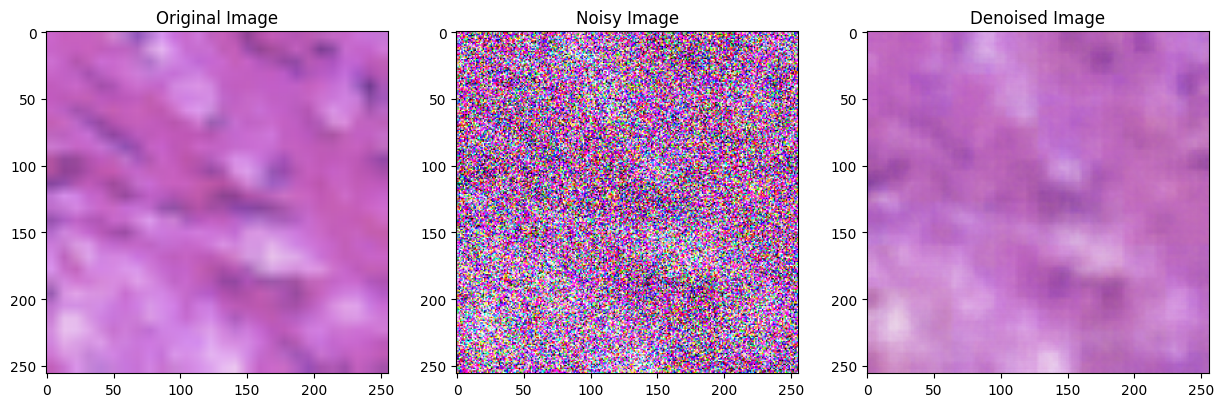

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(test_image.permute(1, 2, 0))

plt.subplot(1, 3, 2)
plt.title('Noisy Image')
plt.imshow(noisy_test_image.cpu().permute(1, 2, 0))

plt.subplot(1, 3, 3)
plt.title('Denoised Image')
plt.imshow(denoised_image.permute(1, 2, 0))

plt.show()

In [ ]:
import torchvision.utils as vutils

# Organize 1 image from each class (PathMNIST has labels from 0–8)
class_images = {}
for img, label in val_dataset:
    label = int(label)
    if label not in class_images:
        class_images[label] = img
    if len(class_images) == 9:
        break

<ipython-input-17-ef8b93f7d1af>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)


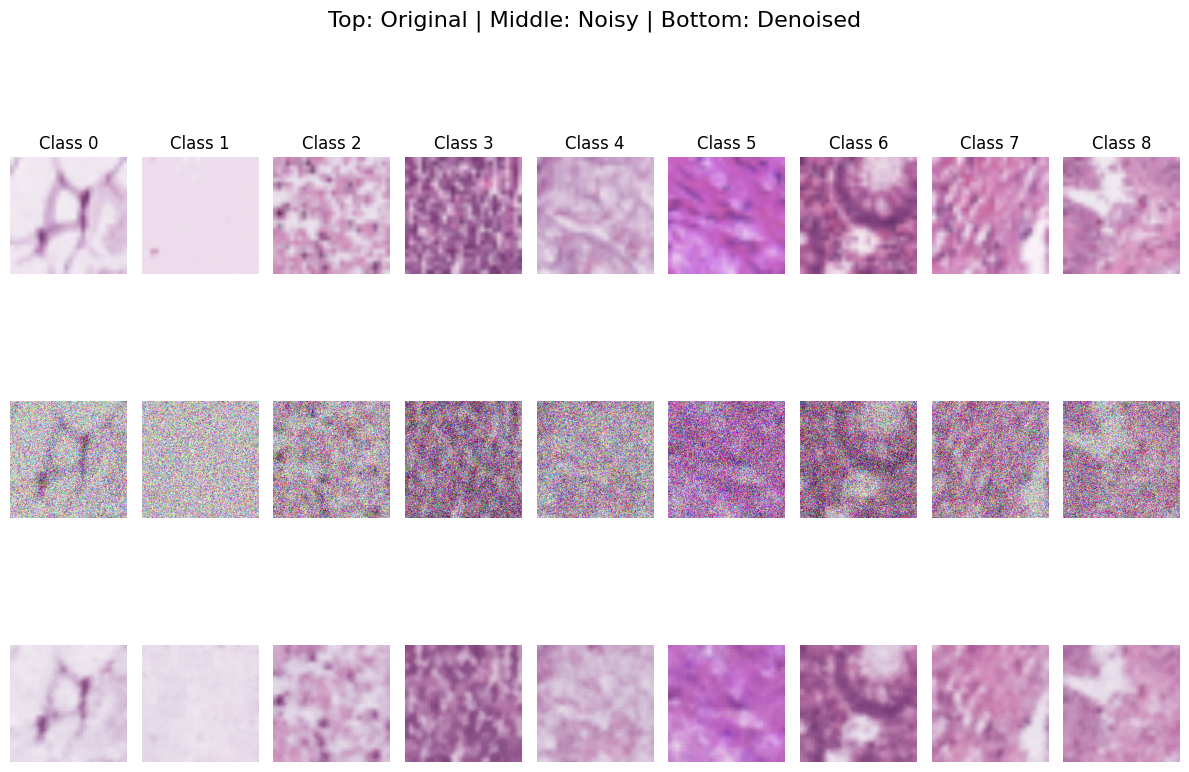

In [ ]:
# Create figure
plt.figure(figsize=(12, 9))

for i, class_idx in enumerate(sorted(class_images.keys())):
    original = class_images[class_idx]
    noisy = add_noise(original).to(device)
    denoised = denoise_image(noisy, model)

    # PSNR and SSIM (Optional)
    p = calculate_psnr(original, denoised)
    s = calculate_ssim(original, denoised)

    # Original
    plt.subplot(3, 9, i + 1)
    plt.imshow(original.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f'Class {class_idx}')

    # Noisy
    plt.subplot(3, 9, i + 10)
    plt.imshow(noisy.cpu().permute(1, 2, 0))
    plt.axis('off')

    # Denoised
    plt.subplot(3, 9, i + 19)
    plt.imshow(denoised.permute(1, 2, 0))
    plt.axis('off')

plt.suptitle("Top: Original | Middle: Noisy | Bottom: Denoised", fontsize=16)
plt.tight_layout()
plt.show()